<a href="https://colab.research.google.com/github/Elinab04/Book-Analysis/blob/main/Book_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting to Google Books API

In [7]:
from google.colab import userdata

key = userdata.get("GOOGLE_BOOKS_API_KEY")

if key:
    print("API key loaded successfully")
else:
    print("API key NOT loaded – check Secrets and Notebook access")



API key loaded successfully


In [10]:
import requests, json

BASE_URL = "https://www.googleapis.com/books/v1/volumes"

params = {
    "q": "harry potter",
    "maxResults": 5,
    "key": key
}

response = requests.get(BASE_URL, params=params, timeout=30)
print("Status code:", response.status_code)

data = response.json()

if "error" in data:
    print("API error:")
    print(json.dumps(data["error"], indent=2))
else:
    print("Top-level keys:", list(data.keys()))
    print("Total items:", data.get("totalItems"))
    print("Items returned:", len(data.get("items", [])))

Status code: 200
Top-level keys: ['kind', 'totalItems', 'items']
Total items: 1000000
Items returned: 5


In [12]:
import time
import requests
import pandas as pd

BASE_URL = "https://www.googleapis.com/books/v1/volumes"

def fetch_page(query, start_index=0, max_results=40):
    params = {
        "q": query,
        "printType": "books",
        "langRestrict": "en",
        "startIndex": start_index,
        "maxResults": max_results,
        "key": key
    }
    r = requests.get(BASE_URL, params=params, timeout=30)

    # If quota/rate limit hit, stop with a clear error
    if r.status_code == 429:
        raise RuntimeError("HTTP 429: Quota/rate limit hit. Wait or check Google Cloud quotas.")
    r.raise_for_status()
    return r.json()

def collect_1000_books(target_n=1000, page_size=40, sleep_seconds=0.7):
    # Multiple queries reduces duplicates and increases variety
    queries = [
        "subject:fiction", "subject:romance", "subject:fantasy", "subject:thriller",
        "subject:mystery", "subject:history", "subject:biography", "subject:science",
        "subject:business", "subject:technology", "subject:young adult",
        "subject:poetry", "subject:children", "subject:health", "subject:psychology",
        "subject:travel"
    ]

    seen_ids = set()
    rows = []

    for q in queries:
        if len(seen_ids) >= target_n:
            break

        print(f"\n--- Query: {q} ---")

        # up to 25 pages per query (25*40 = 1000) but we break early once we hit 1000 total
        for page in range(25):
            if len(seen_ids) >= target_n:
                break

            start_index = page * page_size
            data = fetch_page(q, start_index=start_index, max_results=page_size)
            items = data.get("items", [])

            if not items:
                print(f"No items returned at startIndex={start_index}. Moving to next query.")
                break

            new_added = 0
            for item in items:
                book_id = item.get("id")
                if not book_id or book_id in seen_ids:
                    continue

                vol = item.get("volumeInfo", {})
                rows.append({
                    "id": book_id,
                    "title": vol.get("title"),
                    "authors": ", ".join(vol.get("authors", [])) if vol.get("authors") else None,
                    "publishedDate": vol.get("publishedDate"),
                    "categories": ", ".join(vol.get("categories", [])) if vol.get("categories") else None,
                    "description": vol.get("description"),
                    "averageRating": vol.get("averageRating"),
                    "ratingsCount": vol.get("ratingsCount"),
                    "source_query": q
                })
                seen_ids.add(book_id)
                new_added += 1

                # stop immediately once we hit exactly 1000
                if len(seen_ids) >= target_n:
                    break

            print(f"Page {page+1} | startIndex={start_index} | +{new_added} new | total={len(seen_ids)}")
            time.sleep(sleep_seconds)

    df = pd.DataFrame(rows).drop_duplicates(subset=["id"]).reset_index(drop=True)

    # If we accidentally collected slightly above due to dedupe timing, trim to 1000
    df = df.head(target_n).copy()
    return df


In [13]:
df = collect_1000_books(target_n=1000, page_size=40, sleep_seconds=0.7)

print("\nFinal rows:", len(df))
print("Unique IDs:", df["id"].nunique())
df.head()




--- Query: subject:fiction ---
Page 1 | startIndex=0 | +20 new | total=20
Page 2 | startIndex=40 | +20 new | total=40
Page 3 | startIndex=80 | +20 new | total=60
Page 4 | startIndex=120 | +20 new | total=80
Page 5 | startIndex=160 | +20 new | total=100
No items returned at startIndex=200. Moving to next query.

--- Query: subject:romance ---
Page 1 | startIndex=0 | +20 new | total=120
Page 2 | startIndex=40 | +20 new | total=140
Page 3 | startIndex=80 | +20 new | total=160
Page 4 | startIndex=120 | +20 new | total=180
Page 5 | startIndex=160 | +20 new | total=200
No items returned at startIndex=200. Moving to next query.

--- Query: subject:fantasy ---
Page 1 | startIndex=0 | +20 new | total=220
Page 2 | startIndex=40 | +20 new | total=240
Page 3 | startIndex=80 | +20 new | total=260
Page 4 | startIndex=120 | +20 new | total=280
No items returned at startIndex=160. Moving to next query.

--- Query: subject:thriller ---
Page 1 | startIndex=0 | +19 new | total=299
Page 2 | startIndex=40

,id,title,authors,publishedDate,categories,description,averageRating,ratingsCount,source_query
0,icKmd-tlvPMC,Journey to the Center of the Earth,Jules Verne,2006-04-25,Fiction,The intrepid Professor Lindenbrock embarks upo...,3.5,3.0,subject:fiction
1,XdMBTKWSfeMC,Taras Bulba,Nikolái V. Gogol,2006-12-19,Literary Criticism,"Feroces, crueles, valientes y apasionados, los...",NaN,NaN,subject:fiction
2,OqAFAQAAIAAJ,Mrs. Dalloway,Virginia Woolf,1925,Fiction,"Heralded as Virginia Woolf's greatest novel, t...",NaN,NaN,subject:fiction
3,lyWOEQAAQBAJ,Frankenstein,Mary Shelley,2025-10-10,Fiction,"Frankenstein; or, The Modern Prometheus is an ...",NaN,NaN,subject:fiction
4,MRoMUV2kLZEC,Mysteries,Knut Hamsun,2001-01-01,Fiction,The first complete English translation of the ...,4.0,3.0,subject:fiction


In [15]:
data = fetch_page("subject:fiction", start_index=0, max_results=40)
print("Items returned:", len(data.get("items", [])))


Items returned: 20


In [17]:
import time
import requests
import pandas as pd

BASE_URL = "https://www.googleapis.com/books/v1/volumes"

def fetch_page(query, start_index=0, page_size=20):
    params = {
        "q": query,
        "printType": "books",
        "langRestrict": "en",
        "startIndex": start_index,
        "maxResults": page_size,   # API effectively caps at 20 for you
        "orderBy": "newest",       # helps with recent books + more pages
        "key": key
    }
    r = requests.get(BASE_URL, params=params, timeout=30)
    r.raise_for_status()
    return r.json()


def collect_1000_books(target_n=1000, page_size=20, pages_per_query=12, sleep_seconds=0.8):
    """
    Designed for environments where Google Books returns ~20 items per page.
    """
    queries = [
        # subject-based
        "subject:fiction", "subject:romance", "subject:fantasy", "subject:thriller",
        "subject:mystery", "subject:history", "subject:biography", "subject:science",
        "subject:business", "subject:technology", "subject:young adult",
        "subject:poetry", "subject:children", "subject:health", "subject:psychology",
        "subject:travel",

        # keyword-based (important to reach 1000)
        "novel 2024", "novel 2023", "novel 2022",
        "debut novel", "award winning novel", "bestseller novel",
        "romantic comedy", "historical fiction", "coming of age",
        "family saga", "dystopian", "space opera", "climate fiction",
        "true crime", "memoir", "self help", "cookbook"
    ]

    seen_ids = set()
    rows = []

    for q in queries:
        if len(seen_ids) >= target_n:
            break

        print(f"\n--- Query: {q} ---")

        for page in range(pages_per_query):
            if len(seen_ids) >= target_n:
                break

            start_index = page * page_size
            data = fetch_page(q, start_index=start_index, page_size=page_size)
            items = data.get("items", [])

            if not items:
                print(f"No items at startIndex={start_index}. Next query.")
                break

            new_added = 0
            for item in items:
                book_id = item.get("id")
                if not book_id or book_id in seen_ids:
                    continue

                vol = item.get("volumeInfo", {})
                rows.append({
                    "id": book_id,
                    "title": vol.get("title"),
                    "authors": ", ".join(vol.get("authors", [])) if vol.get("authors") else None,
                    "publishedDate": vol.get("publishedDate"),
                    "categories": ", ".join(vol.get("categories", [])) if vol.get("categories") else None,
                    "description": vol.get("description"),
                    "averageRating": vol.get("averageRating"),
                    "ratingsCount": vol.get("ratingsCount"),
                    "source_query": q
                })

                seen_ids.add(book_id)
                new_added += 1

                if len(seen_ids) >= target_n:
                    break

            print(f"Page {page+1}/{pages_per_query} | startIndex={start_index} | "
                  f"returned={len(items)} | +{new_added} new | total={len(seen_ids)}")

            time.sleep(sleep_seconds)

    df = pd.DataFrame(rows).drop_duplicates(subset=["id"]).reset_index(drop=True)

    # Trim just in case
    df = df.head(target_n).copy()
    return df


In [18]:
df = collect_1000_books(target_n=1000, page_size=20, pages_per_query=12, sleep_seconds=0.9)

print("\nFinal rows:", len(df))
print("Unique IDs:", df['id'].nunique())



--- Query: subject:fiction ---
Page 1/12 | startIndex=0 | returned=20 | +20 new | total=20
Page 2/12 | startIndex=20 | returned=20 | +20 new | total=40
Page 3/12 | startIndex=40 | returned=20 | +20 new | total=60
Page 4/12 | startIndex=60 | returned=20 | +20 new | total=80
Page 5/12 | startIndex=80 | returned=20 | +20 new | total=100
Page 6/12 | startIndex=100 | returned=20 | +20 new | total=120
Page 7/12 | startIndex=120 | returned=20 | +20 new | total=140
Page 8/12 | startIndex=140 | returned=20 | +20 new | total=160
Page 9/12 | startIndex=160 | returned=20 | +20 new | total=180
Page 10/12 | startIndex=180 | returned=20 | +20 new | total=200
No items at startIndex=200. Next query.

--- Query: subject:romance ---
Page 1/12 | startIndex=0 | returned=20 | +20 new | total=220
Page 2/12 | startIndex=20 | returned=20 | +20 new | total=240
Page 3/12 | startIndex=40 | returned=20 | +20 new | total=260
Page 4/12 | startIndex=60 | returned=20 | +20 new | total=280
Page 5/12 | startIndex=80 | 

In [19]:
df.to_csv("google_books_1000_raw.csv", index=False)
print("Saved: google_books_1000_raw.csv")


Saved: google_books_1000_raw.csv


Exploratory Data Analysis

In [20]:
df.shape, df.columns


((1000, 9),
 Index(['id', 'title', 'authors', 'publishedDate', 'categories', 'description',
        'averageRating', 'ratingsCount', 'source_query'],
       dtype='object'))

In [21]:
#check missing values
missing = df.isna().mean().sort_values(ascending=False)
missing.head(10)


,0
ratingsCount,0.848
averageRating,0.848
categories,0.146
description,0.082
authors,0.009
publishedDate,0.003
id,0.000
title,0.000
source_query,0.000


In [22]:
#publication year extraction
df["year"] = df["publishedDate"].astype(str).str.extract(r"(\d{4})").astype(float)
df["year"].value_counts(dropna=False).sort_index().tail(20)


,count
year,
2007.0,23
2008.0,25
2009.0,30
2010.0,26
2011.0,15
2012.0,37
2013.0,23
2014.0,37
2015.0,35


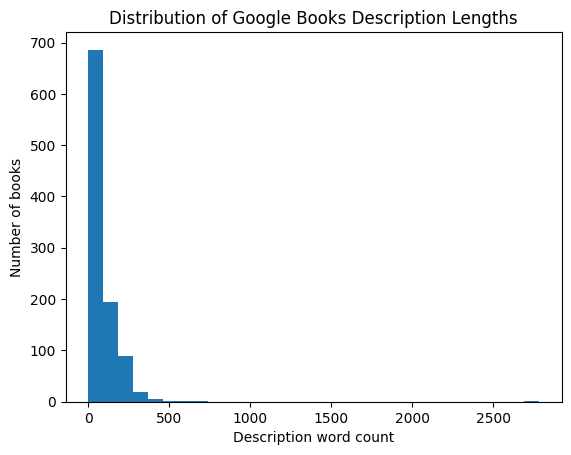

,desc_word_count
count,1000.000000
mean,83.420000
std,121.997594
min,0.000000
25%,23.000000
50%,46.000000
75%,116.250000
max,2784.000000


In [23]:
#description length distribution
import matplotlib.pyplot as plt

df["desc_word_count"] = df["description"].fillna("").str.split().apply(len)

plt.hist(df["desc_word_count"], bins=30)
plt.xlabel("Description word count")
plt.ylabel("Number of books")
plt.title("Distribution of Google Books Description Lengths")
plt.show()

df["desc_word_count"].describe()
